In [ ]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 17.2 MB/s 
     |████████████████████████████████| 182 kB 65.6 MB/s 
     |████████████████████████████████| 7.6 MB 38.8 MB/s 


In [ ]:
# For Weights and Biases
!pip install -qq wandb

     |████████████████████████████████| 1.9 MB 25.4 MB/s 
     |████████████████████████████████| 168 kB 64.9 MB/s 
     |████████████████████████████████| 182 kB 71.5 MB/s 
     |████████████████████████████████| 62 kB 1.5 MB/s 
     |████████████████████████████████| 168 kB 74.4 MB/s 
     |████████████████████████████████| 166 kB 77.4 MB/s 
     |████████████████████████████████| 166 kB 79.3 MB/s 
     |████████████████████████████████| 162 kB 72.6 MB/s 
     |████████████████████████████████| 162 kB 74.9 MB/s 
     |████████████████████████████████| 158 kB 77.9 MB/s 
     |████████████████████████████████| 157 kB 77.9 MB/s 
     |████████████████████████████████| 157 kB 81.5 MB/s 
     |████████████████████████████████| 157 kB 83.1 MB/s 
     |████████████████████████████████| 157 kB 80.7 MB/s 
     |████████████████████████████████| 157 kB 81.5 MB/s 
     |████████████████████████████████| 157 kB 82.6 MB/s 
     |████████████████████████████████| 157 kB 65.9 MB/s 
     |██████████

In [ ]:
import wandb
print("W&B: ", wandb.__version__)
from wandb.keras import WandbCallback

W&B:  0.13.6


In [ ]:
import wandb
from wandb.keras import WandbCallback
# wandb.init(project="hyperparam-test", entity="ariq913")
wandb.init(project="Roberta-test", entity="ariq913")

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


![](img/prepare_dataset_bert.png)

In [ ]:
max_seq_length = 22

In [ ]:
import pandas as pd
df=pd.read_csv("/content/drive/MyDrive/cleaned_twitter_sentiment_data.csv")

In [ ]:
df.head()

,Unnamed: 0,sentiment,message,tweetid
0,0,Anti,climate change is an interesting hustle as it ...,792927353886371840
1,1,Pro,rt watch right here as travels the world to ta...,793124211518832641
2,2,Pro,fabulous leonardo s film on change is brillian...,793124402388832256
3,3,Pro,rt just watched this amazing documentary by le...,793124635873275904
4,4,News,rt pranita biswasi a lutheran from odisha give...,793125156185137153


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43943 entries, 0 to 43942
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  43943 non-null  int64 
 1   sentiment   43943 non-null  object
 2   message     43881 non-null  object
 3   tweetid     43943 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 1.3+ MB


In [ ]:
df["length"]=df["message"].apply(lambda x: len(str(x).split(" ")))

In [ ]:
min(df["length"])

1

In [ ]:
s=set(df["sentiment"])

In [ ]:
ch_to_int={'Anti':-1, 'News':1, 'Pro':2, 'Neutral':0}

In [ ]:
df["sentiment"]=df["sentiment"].apply(lambda x: ch_to_int[x])

In [ ]:
df = df.drop(df[df.length<5].index)


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43559 entries, 0 to 43942
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  43559 non-null  int64 
 1   sentiment   43559 non-null  int64 
 2   message     43559 non-null  object
 3   tweetid     43559 non-null  int64 
 4   length      43559 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 2.0+ MB


In [ ]:
s=set(df["sentiment"])
print(s)

{0, 1, 2, -1}


In [ ]:
df.head()

,Unnamed: 0,sentiment,message,tweetid,length
0,0,-1,climate change is an interesting hustle as it ...,792927353886371840,22
1,1,2,rt watch right here as travels the world to ta...,793124211518832641,13
2,2,2,fabulous leonardo s film on change is brillian...,793124402388832256,12
3,3,2,rt just watched this amazing documentary by le...,793124635873275904,16
4,4,1,rt pranita biswasi a lutheran from odisha give...,793125156185137153,20


# Convert Raw Text to BERT Features using Hugging Face and TensorFlow

In [ ]:
import tensorflow as tf
import collections
import json
import os
import pandas as pd
import csv
# from transformers import DistilBertTokenizer

# tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

from transformers import RobertaTokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')


MESSAGE_COLUMN = "message"
TWEETID_COLUMN = "tweetid"

LABEL_COLUMN = "sentiment"
LABEL_VALUES = [0,1,2,-1]

label_map = {-1:0,0:1,1:2,2:3}
# for (i, label) in enumerate(LABEL_VALUES):
#     label_map[label] = i


class InputFeatures(object):
    """BERT feature vectors."""

    def __init__(self, input_ids, input_mask, segment_ids, label_id, tweet_id, date, label):
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.segment_ids = segment_ids
        self.label_id = label_id
        self.tweet_id = tweet_id
        self.date = date
        self.label = label


class Input(object):
    """A single training/test input for sequence classification."""

    def __init__(self, text, tweet_id, date, label=None):
        """Constructs an Input.
        Args:
          text: string. The untokenized text of the first sequence. For single
            sequence tasks, only this sequence must be specified.
          label: (Optional) string. The label of the example. This should be
            specified for train and dev examples, but not for test examples.
        """
        self.text = text
        self.tweet_id = tweet_id
        self.date = date
        self.label = label


def convert_input(the_input, max_seq_length):
    tokens = tokenizer.tokenize(the_input.text)
    tokens.insert(0, '[CLS]')
    tokens.append('[SEP]')
    # print("**{} tokens**\n{}\n".format(len(tokens), tokens))

    encode_plus_tokens = tokenizer.encode_plus(
        the_input.text,
        padding='max_length', 
        max_length=max_seq_length,
        truncation=True
    )
    
    # The id from the pre-trained BERT vocabulary that represents the token.  (Padding of 0 will be used if the # of tokens is less than `max_seq_length`)
    input_ids = encode_plus_tokens["input_ids"]

    # Specifies which tokens BERT should pay attention to (0 or 1).  Padded `input_ids` will have 0 in each of these vector elements.
    input_mask = encode_plus_tokens["attention_mask"]

    # Segment ids are always 0 for single-sequence tasks such as text classification.  1 is used for two-sequence tasks such as question/answer and next sentence prediction.
    segment_ids = [0] * max_seq_length

    # Label for each training row (`star_rating` 1 through 5)
    label_id = label_map[the_input.label]
    # print("Here ",the_input.tweet_id)
    features = InputFeatures(
        input_ids=input_ids,
        input_mask=input_mask,
        segment_ids=segment_ids,
        label_id=label_id,
        tweet_id=the_input.tweet_id,
        date=the_input.date,
        label=the_input.label,
    )

    # print("**{} input_ids**\n{}\n".format(len(features.input_ids), features.input_ids))
    # print("**{} input_mask**\n{}\n".format(len(features.input_mask), features.input_mask))
    # print("**{} segment_ids**\n{}\n".format(len(features.segment_ids), features.segment_ids))
    # print("**label_id**\n{}\n".format(features.label_id))
    # print("**tweet_id**\n{}\n".format(features.tweet_id))
    # print("**date**\n{}\n".format(features.date))
    # print("**label**\n{}\n".format(features.label))

    return features


# We'll need to transform our data into a format that BERT understands.
# - `text` is the text we want to classify, which in this case, is the `Request` field in our Dataframe.
# - `label` is the star_rating label (1, 2, 3, 4, 5) for our training input data
def transform_inputs_to_tfrecord(inputs, output_file, max_seq_length):
    records = []
    tf_record_writer = tf.io.TFRecordWriter(output_file)

    for (input_idx, the_input) in enumerate(inputs):
        if input_idx % 10000 == 0:
            print("Writing input {} of {}\n".format(input_idx, len(inputs)))
       
        features = convert_input(the_input, max_seq_length)

        all_features = collections.OrderedDict()

        # Create TFRecord With input_ids, input_mask, segment_ids, and label_ids
        all_features["input_ids"] = tf.train.Feature(int64_list=tf.train.Int64List(value=features.input_ids))
        all_features["input_mask"] = tf.train.Feature(int64_list=tf.train.Int64List(value=features.input_mask))
        all_features["segment_ids"] = tf.train.Feature(int64_list=tf.train.Int64List(value=features.segment_ids))
        all_features["label_ids"] = tf.train.Feature(int64_list=tf.train.Int64List(value=[features.label_id]))

        tf_record = tf.train.Example(features=tf.train.Features(feature=all_features))
        tf_record_writer.write(tf_record.SerializeToString())

        # Create Record For Feature Store With All Features
        records.append(
            {
                "input_ids": features.input_ids,
                "input_mask": features.input_mask,
                "segment_ids": features.segment_ids,
                "label_id": features.label_id,
                "tweet_id": the_input.tweet_id,
                "date": the_input.date,
                "label": features.label,
            }
        )

    tf_record_writer.close()

    return records

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [ ]:
df_grouped_by = df.groupby(["sentiment"])
df_balanced = df_grouped_by.apply(
            lambda x: x.sample(df_grouped_by.size().min()).reset_index(drop=True)
        )
df_balanced = df_balanced.reset_index(drop=True)
print("Shape of balanced dataframe {}".format(df_balanced.shape))

print(df_balanced["sentiment"].head(2))
print(df_balanced["message"].head(2))

df = df_balanced
df = df.sample(frac=1).reset_index(drop=True)
df = df.sample(frac=1).reset_index(drop=True)

Shape of balanced dataframe (15832, 5)
0   -1
1   -1
Name: sentiment, dtype: int64
0    debunking the claim they changed global warmin...
1    and climate change hasn t killed any if past p...
Name: message, dtype: object


In [ ]:
from sklearn.model_selection import train_test_split
train_split_percentage=0.9
test_split_percentage=0.05


In [ ]:
holdout_percentage = 1.00 - train_split_percentage
print("holdout percentage {}".format(holdout_percentage))

df_train, df_holdout = train_test_split(
        df, test_size=holdout_percentage, stratify=df["sentiment"]
    )

test_holdout_percentage = test_split_percentage / holdout_percentage

print("test holdout percentage {}".format(test_holdout_percentage))

df_validation, df_test = train_test_split(
        df_holdout, test_size=test_holdout_percentage, stratify=df_holdout["sentiment"]
    )

df_train = df_train.reset_index(drop=True)
df_validation = df_validation.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)


holdout percentage 0.09999999999999998
test holdout percentage 0.5000000000000001


In [ ]:
df_test.to_csv("test.csv")

In [ ]:


from datetime import datetime
from time import gmtime, strftime, sleep
timestamp = datetime.now().strftime("%Y-%m-%dT%H:%M:%SZ")
train_inputs = df_train.apply(
        lambda x: Input(
            label=x[LABEL_COLUMN],
            text=x[MESSAGE_COLUMN],
            tweet_id=x[TWEETID_COLUMN],
            date=timestamp,
        ),
        axis=1,
    )

validation_inputs = df_validation.apply(
        lambda x: Input(
            label=x[LABEL_COLUMN],
            text=x[MESSAGE_COLUMN],
            tweet_id=x[TWEETID_COLUMN],
            date=timestamp,
        ),
        axis=1,
    )

test_inputs = df_test.apply(
        lambda x: Input(
            label=x[LABEL_COLUMN],
            text=x[MESSAGE_COLUMN],
            tweet_id=x[TWEETID_COLUMN],
            date=timestamp,
        ),
        axis=1,
    )


In [ ]:
output_file = "data.tfrecord"

In [ ]:
train_data = "/content/drive/MyDrive/bert/train/{}".format(output_file)
validation_data = "/content/drive/MyDrive/bert/validation/{}".format(output_file)
test_data = "/content/drive/MyDrive/bert/test/{}".format(output_file)

In [ ]:
train_data

'/content/drive/MyDrive/bert/train/data.tfrecord'

In [ ]:
mkdir bert

'/content'

In [ ]:
!touch $train_data

In [ ]:
# !touch $validation_data
!touch $test_data

In [ ]:
tr_rec=transform_inputs_to_tfrecord(
        train_inputs,
        train_data,
        max_seq_length,
    )

val_rec=transform_inputs_to_tfrecord(
        validation_inputs,
        validation_data,
        max_seq_length,
    )

te_rec=transform_inputs_to_tfrecord(
        test_inputs,
        test_data,
        max_seq_length,
    )

Writing input 0 of 14248

Writing input 10000 of 14248

Writing input 0 of 791

Writing input 0 of 793



In [ ]:
import pandas as pd

tr_records = pd.DataFrame.from_dict(tr_rec)
tr_records["split_type"] = "train"
tr_records

,input_ids,input_mask,segment_ids,label_id,tweet_id,date,label,split_type
0,"[0, 9713, 52, 218, 326, 2333, 7244, 9, 24447, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3,940128423397146626,2022-12-06T18:56:56Z,2,train
1,"[0, 9713, 475, 338, 992, 179, 1071, 37, 26, 95...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,958577165699878912,2022-12-06T18:56:56Z,0,train
2,"[0, 9713, 54, 161, 1228, 3519, 16, 562, 4487, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,953709152827822080,2022-12-06T18:56:56Z,0,train
3,"[0, 4651, 638, 44, 711, 44970, 17, 27, 5933, 7...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,640206110151081984,2022-12-06T18:56:56Z,-1,train
4,"[0, 16714, 8807, 720, 8232, 460, 817, 5, 340, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,868437485541576705,2022-12-06T18:56:56Z,-1,train
...,...,...,...,...,...,...,...,...
14243,"[0, 25800, 123, 16, 1368, 260, 67, 6908, 185, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,958239516271132673,2022-12-06T18:56:56Z,0,train
14244,"[0, 8287, 145, 38909, 836, 10229, 22241, 1315,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,613141648692932608,2022-12-06T18:56:56Z,-1,train
14245,"[0, 118, 2813, 720, 8232, 2425, 14, 939, 74, 2...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3,800698100373286912,2022-12-06T18:56:56Z,2,train
14246,"[0, 9713, 6255, 268, 3968, 632, 573, 1856, 16,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2,654110652756197376,2022-12-06T18:56:56Z,1,train


In [ ]:
val_records = pd.DataFrame.from_dict(val_rec)
val_records["split_type"] = "validation"
val_records

,input_ids,input_mask,segment_ids,label_id,tweet_id,date,label,split_type
0,"[0, 9713, 16, 42, 147, 120, 49, 1114, 14, 2147...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,672766644637143040,2022-12-06T18:56:56Z,-1,validation
1,"[0, 179, 42, 169, 1236, 1851, 1809, 888, 2607,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3,952347480766771200,2022-12-06T18:56:56Z,2,validation
2,"[0, 12229, 27121, 219, 794, 110, 3545, 1423, 2...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,819279373438164993,2022-12-06T18:56:56Z,-1,validation
3,"[0, 8155, 579, 567, 66, 7, 192, 162, 3008, 248...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,829243149134491648,2022-12-06T18:56:56Z,0,validation
4,"[0, 9713, 720, 8232, 40, 478, 22555, 749, 1111...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2,732619240788918273,2022-12-06T18:56:56Z,1,validation
...,...,...,...,...,...,...,...,...
786,"[0, 9713, 1407, 5, 418, 720, 8232, 16, 122, 10...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,630451451752501248,2022-12-06T18:56:56Z,-1,validation
787,"[0, 9226, 266, 14524, 141, 602, 5, 4263, 9, 80...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,808008486030348288,2022-12-06T18:56:56Z,0,validation
788,"[0, 9713, 18363, 1439, 26250, 1368, 2013, 607,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2,844099871196008450,2022-12-06T18:56:56Z,1,validation
789,"[0, 9713, 5, 1104, 790, 161, 2147, 464, 1435, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2,843730941684125696,2022-12-06T18:56:56Z,1,validation


# Cast DataFrame `Object` to Supported Feature Store Data Type `String`

In [ ]:
def cast_object_to_string(data_frame):
    for label in data_frame.columns:
        if data_frame.dtypes[label] == "object":
            data_frame[label] = data_frame[label].astype("str").astype("string")

In [ ]:
import tensorflow as tf
from transformers import RobertaTokenizer
from transformers import TFRobertaForSequenceClassification,TFAutoModelForSequenceClassification
from transformers import RobertaConfig

In [ ]:
def select_data_and_label_from_record(record):
    x = {
        "input_ids": record["input_ids"],
        "input_mask": record["input_mask"],
    }
    y = record["label_ids"]

    return (x, y)

In [ ]:
def file_based_input_dataset_builder(channel, input_filenames, max_seq_length, is_training, drop_remainder):
    # For training, we want a lot of parallel reading and shuffling.
    # For eval, we want no shuffling and parallel reading doesn't matter.

    dataset = tf.data.TFRecordDataset(input_filenames)
    dataset = dataset.repeat(100)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

    name_to_features = {
        "input_ids": tf.io.FixedLenFeature([max_seq_length], tf.int64),
        "input_mask": tf.io.FixedLenFeature([max_seq_length], tf.int64),
        "label_ids": tf.io.FixedLenFeature([], tf.int64),
    }

    def _decode_record(record, name_to_features):
        """Decodes a record to a TensorFlow example."""
        return tf.io.parse_single_example(record, name_to_features)

    dataset = dataset.apply(
        tf.data.experimental.map_and_batch(
            lambda record: _decode_record(record, name_to_features),
            batch_size=16,
            drop_remainder=drop_remainder,
            num_parallel_calls=tf.data.experimental.AUTOTUNE,
        )
    )

    dataset.cache()

    if is_training:
        dataset = dataset.shuffle(seed=42, buffer_size=10, reshuffle_each_iteration=True)

    return dataset

In [ ]:

train_dataset = file_based_input_dataset_builder(
    channel="train", input_filenames=train_data, max_seq_length=max_seq_length, is_training=True, drop_remainder=False
).map(select_data_and_label_from_record)

Instructions for updating:
Use `tf.data.Dataset.map(map_func, num_parallel_calls)` followed by `tf.data.Dataset.batch(batch_size, drop_remainder)`. Static tf.data optimizations will take care of using the fused implementation.


In [ ]:
train_dataset

<MapDataset element_spec=({'input_ids': TensorSpec(shape=(None, 22), dtype=tf.int64, name=None), 'input_mask': TensorSpec(shape=(None, 22), dtype=tf.int64, name=None)}, TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
validation_dataset = file_based_input_dataset_builder(
    channel="validation",
    input_filenames=validation_data,
    max_seq_length=max_seq_length,
    is_training=False,
    drop_remainder=False,
).map(select_data_and_label_from_record)

In [ ]:
validation_dataset

<MapDataset element_spec=({'input_ids': TensorSpec(shape=(None, 22), dtype=tf.int64, name=None), 'input_mask': TensorSpec(shape=(None, 22), dtype=tf.int64, name=None)}, TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
test_dataset = file_based_input_dataset_builder(
    channel="test",
    input_filenames=test_data,
    max_seq_length=max_seq_length,
    is_training=False,
    drop_remainder=False,
).map(select_data_and_label_from_record)

In [ ]:
epochs = 180
steps_per_epoch = 50
validation_steps = 50
test_steps = 50
freeze_bert_layer = True
learning_rate = 3e-5
epsilon = 1e-08
max_seq_length = max_seq_length

In [ ]:
wandb.config = {
    "epochs":epochs,
  "learning_rate": learning_rate,
  "max_seq_length": max_seq_length,
  "freeze_bert_layer":freeze_bert_layer,
  "number_of_freeze":2
  
}

In [ ]:
CLASSES = [-1,0,1,2]

config = RobertaTokenizer.from_pretrained(
    "roberta-base",
    num_labels=len(CLASSES),
    id2label={0:-1,1:0,2:1,3:2},
    label2id={-1:0,0:1,1:2,2:3},
)
print(config)

PreTrainedTokenizer(name_or_path='roberta-base', vocab_size=50265, model_max_len=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'eos_token': AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'unk_token': AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'sep_token': AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'pad_token': AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'cls_token': AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=True)})


In [ ]:
transformer_model = TFAutoModelForSequenceClassification.from_pretrained("roberta-base", config=config)

input_ids = tf.keras.layers.Input(shape=(max_seq_length,), name="input_ids", dtype="int32")
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), name="input_mask", dtype="int32")

embedding_layer = transformer_model.roberta(input_ids, attention_mask=input_mask)[0]
X = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(
    embedding_layer
)
X = tf.keras.layers.GlobalMaxPool1D()(X)
X = tf.keras.layers.Dense(32, activation="relu")(X)
X = tf.keras.layers.Dropout(0.2)(X)
X = tf.keras.layers.Dense(len(CLASSES), activation="softmax")(X)

model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=X)

for layer in model.layers[:2]:
    layer.trainable = not freeze_bert_layer

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=32)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

metric = tf.keras.metrics.SparseCategoricalAccuracy("accuracy")

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=epsilon)

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 22)]         0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 22)]         0           []                               
                                                                                                  
 roberta (TFRobertaMainLayer)   TFBaseModelOutputWi  124055040   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'input_mask[0][0]']             
                                tentions(last_hidde                                               
                                n_state=(None, 22,                                          

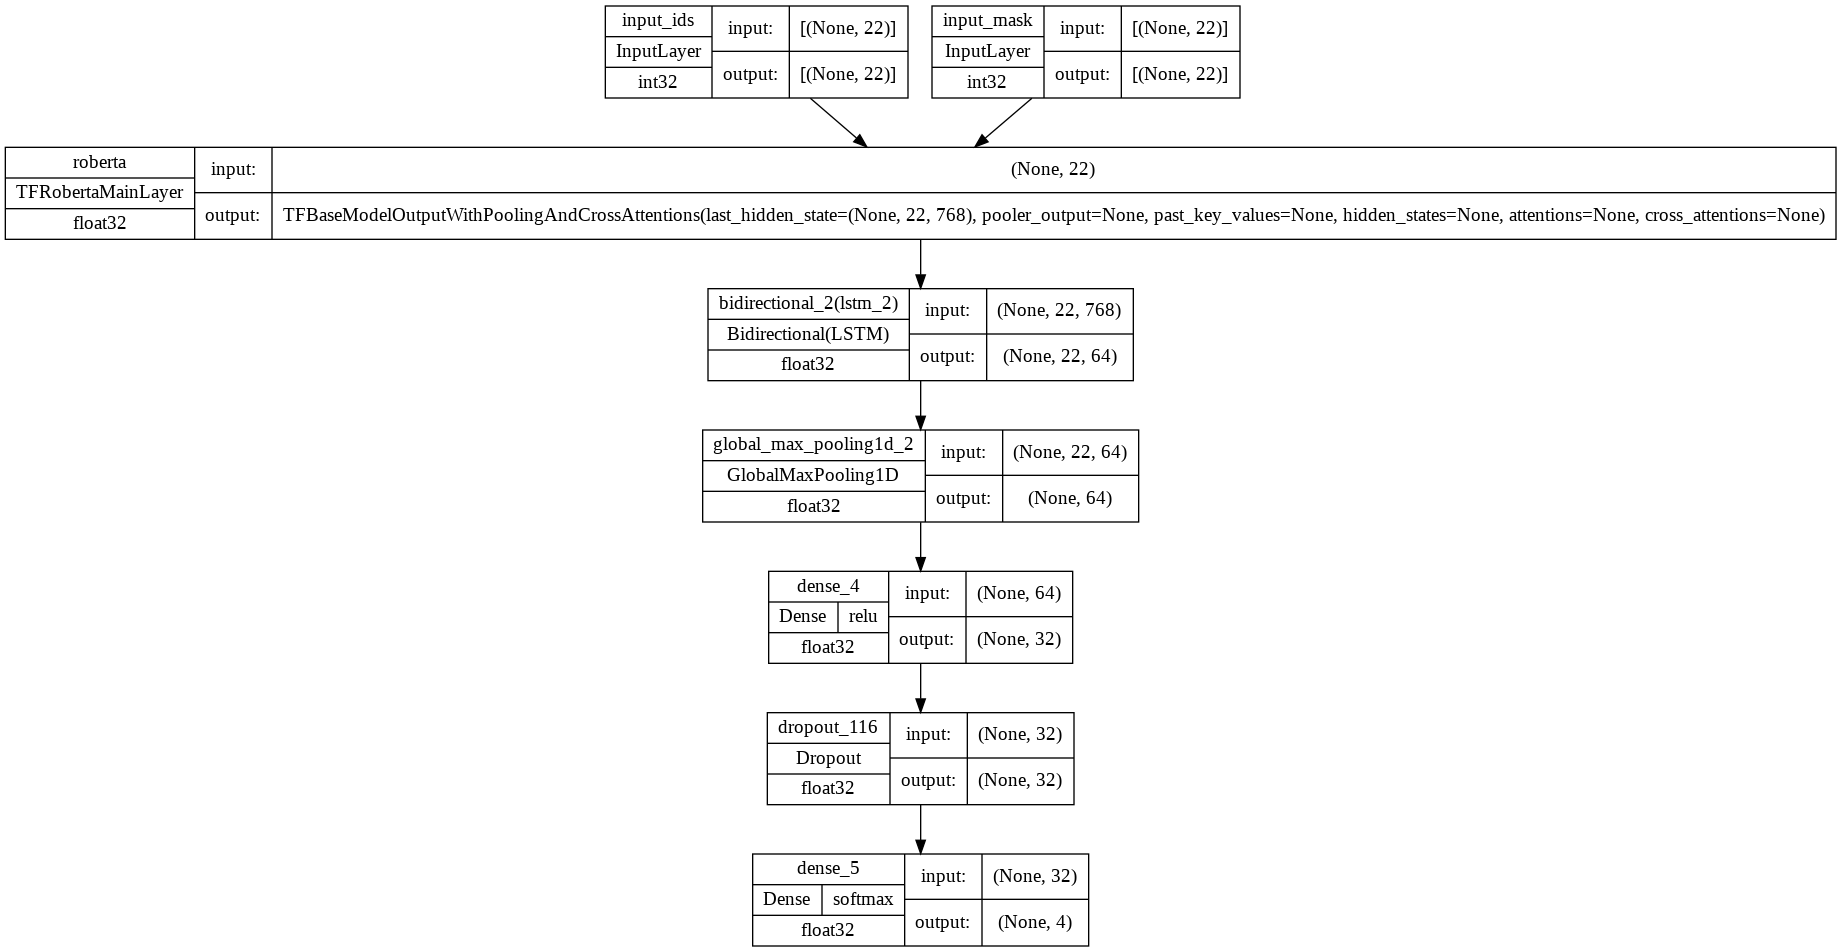

In [ ]:
tf.keras.utils.plot_model(
    model,
    to_file="/content/drive/MyDrive/bert/robera_model.png",
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=True,
)

In [ ]:
history = model.fit(
    train_dataset,
    shuffle=True,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_dataset,
    validation_steps=validation_steps,
    verbose=2,
    callbacks=[WandbCallback(),es]
    # callbacks=callbacks,
)

Epoch 1/180


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


50/50 - 47s - loss: 1.3692 - accuracy: 0.3288 - val_loss: 1.3028 - val_accuracy: 0.4238 - 47s/epoch - 946ms/step
Epoch 2/180
50/50 - 19s - loss: 1.2654 - accuracy: 0.4375 - val_loss: 1.1603 - val_accuracy: 0.5125 - 19s/epoch - 375ms/step
Epoch 3/180
50/50 - 18s - loss: 1.1918 - accuracy: 0.4700 - val_loss: 1.1144 - val_accuracy: 0.5213 - 18s/epoch - 355ms/step
Epoch 4/180
50/50 - 17s - loss: 1.1183 - accuracy: 0.5437 - val_loss: 1.0873 - val_accuracy: 0.5550 - 17s/epoch - 346ms/step
Epoch 5/180
50/50 - 20s - loss: 1.0750 - accuracy: 0.5525 - val_loss: 0.9651 - val_accuracy: 0.6375 - 20s/epoch - 391ms/step
Epoch 6/180
50/50 - 17s - loss: 1.0834 - accuracy: 0.5412 - val_loss: 1.0629 - val_accuracy: 0.5875 - 17s/epoch - 342ms/step
Epoch 7/180
50/50 - 18s - loss: 1.0393 - accuracy: 0.5813 - val_loss: 0.9490 - val_accuracy: 0.6388 - 18s/epoch - 350ms/step
Epoch 8/180
50/50 - 18s - loss: 0.9965 - accuracy: 0.6112 - val_loss: 0.8973 - val_accuracy: 0.6538 - 18s/epoch - 356ms/step
Epoch 9/180


wandb: Adding directory to artifact (/content/wandb/run-20221206_185314-1ylewo3y/files/model-best)... Done. 8.7s


50/50 - 72s - loss: 0.7667 - accuracy: 0.7125 - val_loss: 0.7634 - val_accuracy: 0.7013 - 72s/epoch - 1s/step
Epoch 37/180
50/50 - 18s - loss: 0.6779 - accuracy: 0.7462 - val_loss: 0.8126 - val_accuracy: 0.6963 - 18s/epoch - 361ms/step
Epoch 38/180
50/50 - 18s - loss: 0.7060 - accuracy: 0.7325 - val_loss: 0.9064 - val_accuracy: 0.6425 - 18s/epoch - 366ms/step
Epoch 39/180
50/50 - 21s - loss: 0.6838 - accuracy: 0.7650 - val_loss: 0.8349 - val_accuracy: 0.6950 - 21s/epoch - 415ms/step
Epoch 40/180
50/50 - 18s - loss: 0.6875 - accuracy: 0.7450 - val_loss: 0.8178 - val_accuracy: 0.6888 - 18s/epoch - 353ms/step
Epoch 41/180
50/50 - 17s - loss: 0.6627 - accuracy: 0.7650 - val_loss: 0.8275 - val_accuracy: 0.6875 - 17s/epoch - 342ms/step
Epoch 42/180
50/50 - 17s - loss: 0.6331 - accuracy: 0.7650 - val_loss: 0.9663 - val_accuracy: 0.6500 - 17s/epoch - 346ms/step
Epoch 43/180
50/50 - 17s - loss: 0.5943 - accuracy: 0.7912 - val_loss: 0.8221 - val_accuracy: 0.7063 - 17s/epoch - 345ms/step
Epoch 44

wandb: Adding directory to artifact (/content/wandb/run-20221206_185314-1ylewo3y/files/model-best)... Done. 8.8s


50/50 - 74s - loss: 0.6514 - accuracy: 0.7663 - val_loss: 0.7526 - val_accuracy: 0.6925 - 74s/epoch - 1s/step
Epoch 51/180
50/50 - 18s - loss: 0.5786 - accuracy: 0.7962 - val_loss: 0.7751 - val_accuracy: 0.6975 - 18s/epoch - 364ms/step
Epoch 52/180
50/50 - 18s - loss: 0.6537 - accuracy: 0.7575 - val_loss: 0.8120 - val_accuracy: 0.6762 - 18s/epoch - 365ms/step
Epoch 53/180
50/50 - 18s - loss: 0.6816 - accuracy: 0.7437 - val_loss: 0.8565 - val_accuracy: 0.6862 - 18s/epoch - 363ms/step
Epoch 54/180
50/50 - 18s - loss: 0.6377 - accuracy: 0.7625 - val_loss: 0.8237 - val_accuracy: 0.6888 - 18s/epoch - 355ms/step
Epoch 55/180
50/50 - 17s - loss: 0.6045 - accuracy: 0.7788 - val_loss: 0.8084 - val_accuracy: 0.6862 - 17s/epoch - 343ms/step
Epoch 56/180
50/50 - 17s - loss: 0.5537 - accuracy: 0.8112 - val_loss: 0.8291 - val_accuracy: 0.6963 - 17s/epoch - 342ms/step
Epoch 57/180
50/50 - 17s - loss: 0.5331 - accuracy: 0.8163 - val_loss: 0.8727 - val_accuracy: 0.6862 - 17s/epoch - 346ms/step
Epoch 58

In [ ]:
ls /content

 bert/          test.csv                    'Untitled Folder'/
 sample_data/   twitter_sentiment_data.csv


In [ ]:
model.save("/content/drive/MyDrive/Roberta/model")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

CLASSES = [-1,0,1,2]

# config = RobertaTokenizer.from_pretrained("roberta-base",
                                             #     num_labels=len(CLASSES),
                                             #  id2label={0:-1,1:0,2:1,3:2},
                                             # label2id={-1:0,0:1,1:2,2:3},
                                             #     )

tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

In [ ]:
def predict(text, model, max_seq_length):
    tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
    
     # config = RobertaTokenizer.from_pretrained("roberta-base",
     #                                             num_labels=len(CLASSES),
     #                                          id2label={0:-1,1:0,2:1,3:2},
     #                                         label2id={-1:0,0:1,1:2,2:3},
     #                                             )
    id2label={0:-1,1:0,2:1,3:2}
    encode_plus_tokens = tokenizer.encode_plus(
        text, 
        padding='max_length', 
        max_length=max_seq_length, 
        truncation=True, 
        return_tensors="tf"
    )
    # The id from the pre-trained BERT vocabulary that represents the token.  (Padding of 0 will be used if the # of tokens is less than `max_seq_length`)
    input_ids = encode_plus_tokens["input_ids"]

    # Specifies which tokens BERT should pay attention to (0 or 1).  Padded `input_ids` will have 0 in each of these vector elements.
    input_mask = encode_plus_tokens["attention_mask"]

    outputs = model.predict(x=(input_ids, input_mask))

    prediction = [{"label": id2label[item.argmax()], "score": item.max().item()} for item in outputs]

    return prediction[0]["label"]

In [ ]:
# from tensorflow import keras
# model = keras.models.load_model('/content/drive/MyDrive/bert/model')

y_test = [predict(message, model, max_seq_length) for message in df_test["message"][:50]]
y_test

y_actual = df_test["sentiment"][:50]
y_actual


1/1 [==============================] - 0s 56ms/step


0     2
1     2
2     2
3    -1
4    -1
5     1
6     1
7    -1
8     1
9     1
10    0
11   -1
12    2
13    0
14    0
15   -1
16    2
17    1
18   -1
19    1
20    1
21   -1
22   -1
23   -1
24    1
25    0
26    0
27    0
28    0
29    1
30   -1
31   -1
32   -1
33    0
34    0
35    2
36    2
37    2
38    0
39    1
40    2
41   -1
42    2
43   -1
44   -1
45   -1
46    1
47    2
48    1
49    1
Name: sentiment, dtype: int64

In [ ]:
valpr=set(y_test)

In [ ]:
valpr

{-1, 0, 1, 2}

In [ ]:
valtr=set(y_actual)

In [ ]:
valtr

{-1, 0, 1, 2}

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [ ]:
classification_report(y_true=y_actual, y_pred=y_test)

'              precision    recall  f1-score   support\n\n          -1       0.75      0.71      0.73        17\n           0       0.60      0.75      0.67         8\n           1       0.92      0.86      0.89        14\n           2       0.73      0.73      0.73        11\n\n    accuracy                           0.76        50\n   macro avg       0.75      0.76      0.75        50\nweighted avg       0.77      0.76      0.76        50\n'

In [ ]:
accuracy = accuracy_score(y_true=y_test, y_pred=y_actual)
print("Test accuracy: ", accuracy)

Test accuracy:  0.76


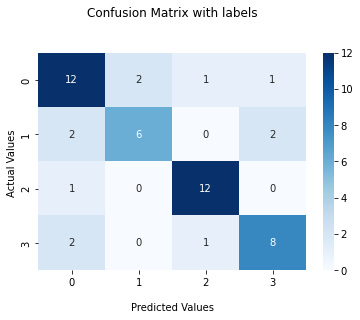

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
cf_matrix = confusion_matrix(y_actual, y_test)
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
# ax.xaxis.set_ticklabels(['False','True'])
# ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:

pip install keras-tuner --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 135 kB 5.3 MB/s 
     |████████████████████████████████| 1.6 MB 43.9 MB/s 


In [ ]:
import keras_tuner as kt

In [ ]:
def build_model(hp):
  transformer_model = TFAutoModelForSequenceClassification.from_pretrained("roberta-base", config=config)
  input_ids = tf.keras.layers.Input(shape=(max_seq_length,), name="input_ids", dtype="int32")
  input_mask = tf.keras.layers.Input(shape=(max_seq_length,), name="input_mask", dtype="int32")
  embedding_layer = transformer_model.roberta(input_ids, attention_mask=input_mask)[0]
  X = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(
    embedding_layer
   )
  X = tf.keras.layers.GlobalMaxPool1D()(X)
  X = tf.keras.layers.Dense(units=hp.Int('units', min_value=32, max_value=128, step=32), activation="relu")(X)
  X = tf.keras.layers.Dropout(0.2)(X)
  X = tf.keras.layers.Dense(len(CLASSES), activation="softmax")(X)

  model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=X)
  freeze_bert_layer=hp.Choice('freezelayer', values=[True,False])
  for layer in model.layers[:hp.Choice('num_freeze_layers', values=[0, 2, 3])]:
    layer.trainable = not freeze_bert_layer
  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

  metric = tf.keras.metrics.SparseCategoricalAccuracy("accuracy")
  learning_rate=hp.Choice("learning_rate",values=[3e-5,(3e-5)*100,(3e-5)/100])
  optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=epsilon)

  model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

  model.summary()
  return model

In [ ]:
import kerastuner as kt
from kerastuner.tuners import RandomSearch, Hyperband, BayesianOptimization
from wandb.keras import WandbCallback

class MyTuner(kt.Tuner):

    def run_trial(self,trial, train_dataset,validation_dataset, steps_per_epoch, epochs, objective):
      
        hp = trial.hyperparameters
        objective_name_str = objective

        ## create the model with the current trial hyperparameters
        model = self.hypermodel.build(hp)
        
        ## Initiates new run for each trial on the dashboard of Weights & Biases
        run = wandb.init(project="roberta-hyperparam-test", entity="ariq913", config=hp.values)

        ## WandbCallback() logs all the metric data such as
        ## loss, accuracy and etc on dashboard for visualization
        history = model.fit(
    train_dataset,
    shuffle=True,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_dataset,
    validation_steps=validation_steps,
    verbose=2,
    callbacks=[WandbCallback()]
    # callbacks=callbacks,
            )
        # history = model.fit(trainX,
        #           trainY,
        #           batch_size=batch_size,
        #           epochs=epochs,
        #           validation_split=0.1,
        #           callbacks=[WandbCallback()])  

        ## if val_accurcy used, use the val_accuracy of last epoch model which is fully trained
        val_acc = history.history['val_accuracy'][-1]  ## [-1] will give the last value in the list

        ## Send the objective data to the oracle for comparison of hyperparameters
        self.oracle.update_trial(trial.trial_id, {objective_name_str:val_acc})

        ## save the trial model
        # self.save_model(trial.trial_id, model)
        
        ## ends the run on the Weights & Biases dashboard
        run.finish()

In [ ]:
## set the objective of tuning algorithm
objective = 'val_accuracy'
  
## instantiate the new Tuner with tuning algorithm and required parameters
tuner = MyTuner(
      oracle=kt.oracles.RandomSearch(
          objective=objective,
          max_trials=4),
      hypermodel=build_model,
      directory='/content/drive/MyDrive/hyperparam/')

tuner.search_space_summary()

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 18)]         0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 18)]         0           []                               
                                                                                                  
 roberta (TFRobertaMainLayer)   TFBaseModelOutputWi  124055040   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'input_mask[0][0]']             
                                tentions(last_hidde                                               
                                n_state=(None, 18,                                          

In [ ]:
tuner.search(train_dataset, validation_dataset, steps_per_epoch=steps_per_epoch, epochs=2, objective=objective)



Trial 4 Complete [00h 02m 39s]
val_accuracy: 0.27250000834465027

Best val_accuracy So Far: 0.4362500011920929
Total elapsed time: 00h 13m 46s


In [ ]:
best_hps = tuner.get_best_hyperparameters()[0]
print(best_hps.values)

## get the best
best_model = tuner.get_best_models()[0]